# Проверка гипотез по увеличению выручки интернет-магазина 

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

Цель: проверить гипотезы интернет-магазина

Задачи:
1. Подготовить данные
2. Приоритизировать гипотезы
3. Провести А/B тестирование

В качестве исходных данных представлены три датафрейма hypothesis, visitors и orders. В датафрейме hypothesis содержится информация о гипотезах увеличения выручки интернет-магазина. В датафрейме visitors содержится информация о клиентах. В датафрейме orders -информация о заказах. 

## Предобработка данных и первый взгляд

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [69]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [4]:
def first_view(df):
    display('Info')
    df.info()
    display('*'*50)
    display('Value counts')
    display(df.value_counts())
    display('*'*50)
    display('Describe')
    display(df.describe())
    display('*'*50)
    display('NAN?')
    display(df.isna().sum())

In [5]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [6]:
# приводим названия столбцов к нижнему регистру и переименовываем столбцы в более удобный вид
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(columns = {'transactionId': 'transaction_id', 'visitorId' : 'visitor_id' })

In [7]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
first_view(orders)

'Info'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


'**************************************************'

'Value counts'

transaction_id  visitor_id  date        revenue  group
1062393         2661240577  2019-08-05  6420     A        1
2883105032      3086835579  2019-08-23  2646     A        1
2875229767      1627549308  2019-08-05  650      B        1
2872509092      983496389   2019-08-02  165      A        1
2866469834      3917749921  2019-08-29  3950     B        1
                                                         ..
1476831880      1422476412  2019-08-14  6180     A        1
1476390797      2044161277  2019-08-31  1450     B        1
1473132782      4069496402  2019-08-12  640      B        1
1472783002      1617417821  2019-08-26  1690     A        1
4293855558      8300375     2019-08-07  1790     A        1
Length: 1197, dtype: int64

'**************************************************'

'Describe'

,transaction_id,visitor_id,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


'**************************************************'

'NAN?'

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

In [9]:
# меняем формат даты с object на datetime 
orders['date'] = pd.to_datetime(orders['date'])

In [10]:
orders.duplicated().sum()

0

In [11]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [12]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
first_view(visitors)

'Info'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


'**************************************************'

'Value counts'

date        group  visitors
2019-08-01  A      719         1
2019-08-24  A      395         1
2019-08-17  B      421         1
2019-08-18  A      668         1
            B      737         1
                              ..
2019-08-13  B      769         1
2019-08-14  A      735         1
            B      746         1
2019-08-15  A      628         1
2019-08-31  B      718         1
Length: 62, dtype: int64

'**************************************************'

'Describe'

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


'**************************************************'

'NAN?'

date        0
group       0
visitors    0
dtype: int64

In [14]:
# меняем формат даты с object на datetime 
visitors['date'] = pd.to_datetime(visitors['date'])

In [15]:
visitors.duplicated().sum()

0

#### Проверяю пользователей, попавших в обе группы

In [16]:
orders['visitor_id'].nunique()

1031

In [17]:
group_a = orders.query('group =="A"')['visitor_id']
group_b = orders.query('group =="B"')['visitor_id']

AB = pd.merge(group_a, group_b, on= 'visitor_id')

AB['visitor_id'].nunique()

58

In [18]:
#AB = AB['visitor_id'].tolist()

In [19]:
#common_ids = AB['visitor_id'].tolist()

In [20]:
(AB['visitor_id'].nunique() / orders['visitor_id'].nunique()) * 100

5.625606207565471

In [21]:
(AB['visitor_id'].count() / orders['visitor_id'].count()) * 100

15.288220551378446

In [22]:
# удаляю пользователей, которые попали в обе группы

AB = AB['visitor_id'].tolist()
orders= orders.query("visitor_id not in @AB")
orders['visitor_id'].nunique()

973

Данные получены хорошие. Пропусков и дубликатов не обнаружено

## Применение фреймворков ICE и RICE


### Примените фреймворк ICE для приоритизации гипотез. Сортируем их по убыванию приоритета.


ICE = impact * confidence * ease

ICE = (impact * confidence) / efforts

In [27]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [28]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'] 

hypothesis.sort_values(by='ice', ascending = False).style\
.highlight_max(color='lavender')\
.highlight_min(color='mistyrose')

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


### Примените фреймворк RICE для приоритизации гипотез. Сортируем их по убыванию приоритета.


RICE = (reach * impact * confidence) / efforts 

In [29]:
hypothesis['rice'] = (hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach']) / hypothesis['efforts'] 
hypothesis.sort_values(by='rice', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


#### Как изменилась приоритизация гипотез при применении RICE вместо ICE? 

In [30]:
hypothesis.sort_values(by = 'rice', ascending = False).style\
.highlight_max(color='lavender')\
.highlight_min(color='mistyrose')


,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.000000


Согласно фреймворку ICE самой приоритетной гипотезой должна стать "Запустить акцию, дающую скидку на товар в день рождения". Согласно фреймворку RICE - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", а запуск акции в день рождения находится далеко не на первом месте. 

Теория по Rice могут иметь больший приоритет по прчине того, что её введение отразится на большем числе пользователей при той же стоимости проведения. В то же время теория по ICE вызывает большую уверенность и лучше отразится а опыте пользования продуктом

## Анализируем A/B-тест:
- [x] Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
- [x] Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
- [x] Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
- [x] Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.
- [x] Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.  Сделайте выводы и предположения.
- [x] Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
- [x] Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
- [x] Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
- [x] Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
-[x] Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. - - Сделайте выводы и предположения.
- [x] Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
- [x] Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.
- [x] Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
- [x] Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

### График кумулятивной выручки по группам

#### Создаю кумулятивный датафрейм

In [31]:
date_group = orders[['date','group']].drop_duplicates()
date_group.duplicated().sum()

0

In [32]:
orders_ag = date_group.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

orders_ag.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [33]:
visitors_ag = date_group.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'nunique'}), axis=1).sort_values(by=['date','group'])

visitors_ag.head()

,date,group,visitors
55,2019-08-01,A,1
66,2019-08-01,B,1
175,2019-08-02,A,2
173,2019-08-02,B,2
291,2019-08-03,A,3


In [34]:
cumulative_df = orders_ag.merge(visitors_ag, left_on= ['date', 'group'], right_on = ['date', 'group'])
cumulative_df.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_df.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,1
1,2019-08-01,B,17,17,59758,1
2,2019-08-02,A,42,36,234381,2
3,2019-08-02,B,40,39,221801,2
4,2019-08-03,A,66,60,346854,3


#### График кумулятивной выручки по группам

In [35]:
cumrev_a = cumulative_df.query('group == "A"')[['date','revenue', 'orders']]
cumrev_b = cumulative_df.query('group == "B"')[['date','revenue', 'orders']]

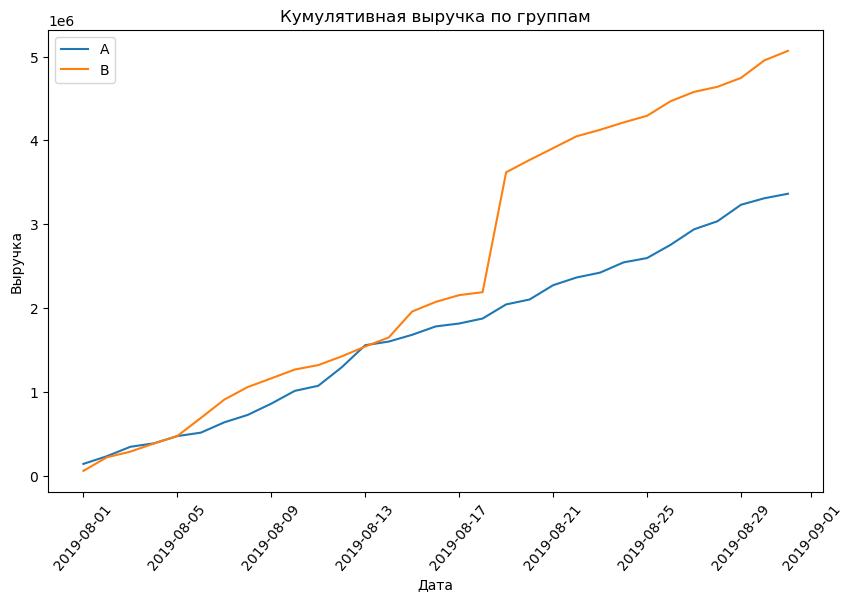

In [36]:
plt.figure(figsize = (10,6))
plt.plot(cumrev_a['date'], cumrev_a['revenue'], label='A')
plt.plot(cumrev_b['date'], cumrev_b['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=50)
plt.legend()
plt.show()

Выручка в обеих группах увеличиваются, но у группы В между 17 и 21 августа обнаруживается резкий рост. Это может быть вызвано резким повышением числа покупок в эти дни

### График кумулятивного среднего чека по группам. 

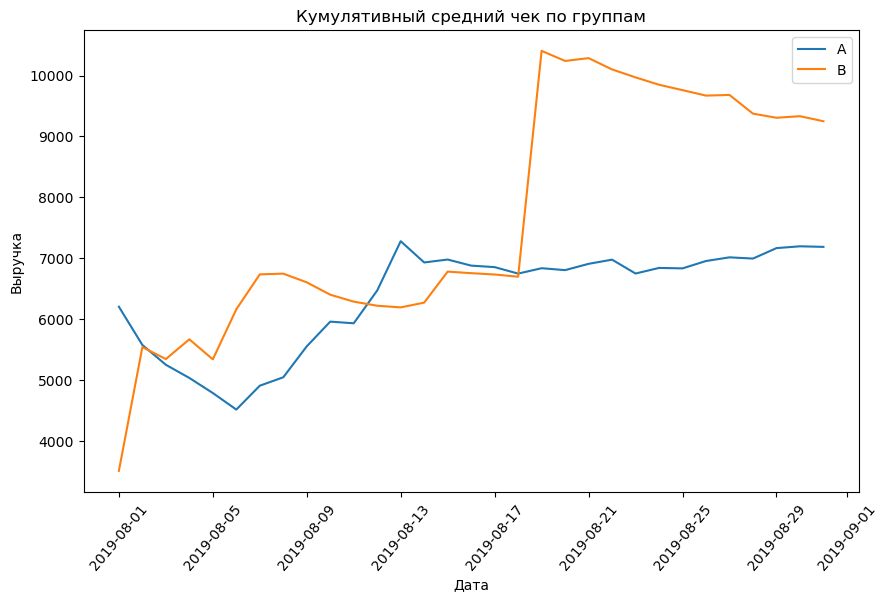

In [37]:
plt.figure(figsize = (10,6))
plt.plot(cumrev_a['date'], cumrev_a['revenue'] /cumrev_a['orders'], label='A')
plt.plot(cumrev_b['date'], cumrev_b['revenue'] /cumrev_b['orders'], label='B')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=50)
plt.legend()
plt.show()

Средний чек между группами в начале флуктуирует, значения среднего чека то растут, то падают. Затем у группы В обнаруживается резкий рост, затем снижение. Это может быть объяснено покупкой на большую сумму. В то же время возножны и ошибки сервера/продавца и т.д. 

### График относительного изменения кумулятивного среднего чека группы B к группе A

In [38]:
cumrev_both = cumrev_a.merge(cumrev_b, left_on = 'date', right_on = 'date', suffixes = ['A', 'B'])
cumrev_both.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


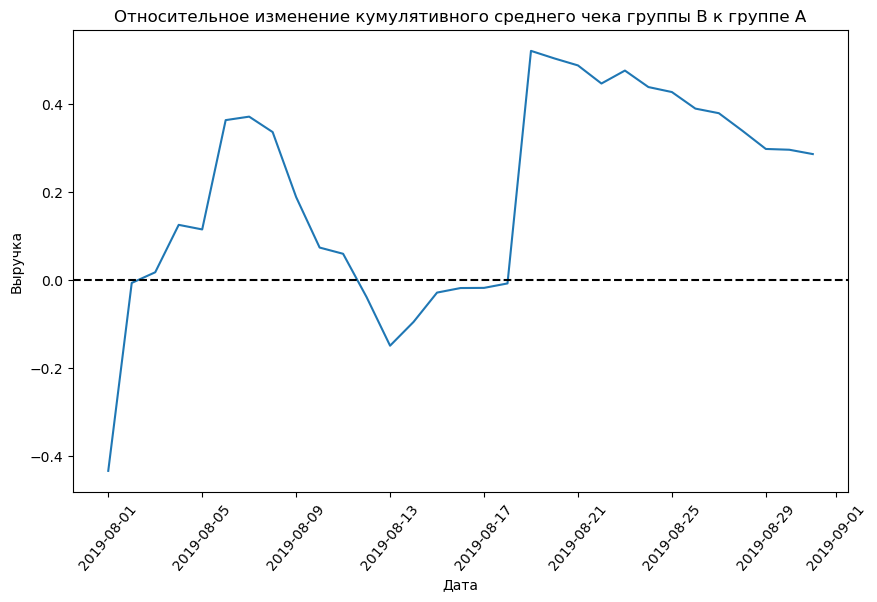

In [39]:
plt.figure(figsize = (10,6))
plt.plot(cumrev_both['date'], (cumrev_both['revenueB']/cumrev_both['ordersB'])/(cumrev_both['revenueA']/cumrev_both['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle ='--')
plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=50)
plt.show()



Из графика видим, что средний чек сильно меняется от одного дня к другому. 9-13 августа произошла сильная просадка и падение среднего чека.

### График кумулятивного среднего количества заказов на посетителя по группам

In [40]:
cumulative_df['conversion'] = cumulative_df['orders']/cumulative_df['visitors']
cumulative_df_a = cumulative_df.query('group =="A"')
cumulative_df_b = cumulative_df.query('group == "B"')

In [41]:
cumulative_df['date'].min()

Timestamp('2019-08-01 00:00:00')

In [42]:
cumulative_df['date'].max()

Timestamp('2019-08-31 00:00:00')

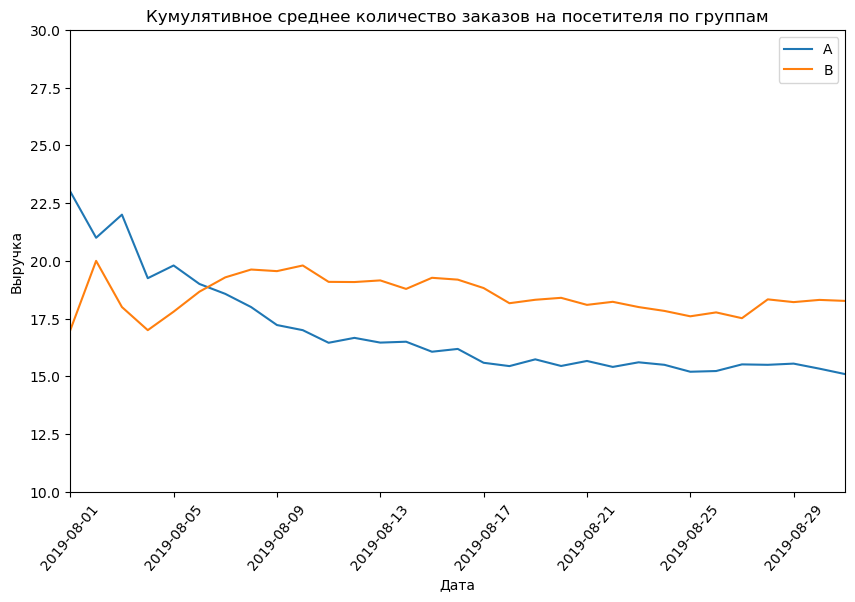

In [43]:
plt.figure(figsize = (10,6))
plt.plot(cumulative_df_a['date'], cumulative_df_a['conversion'], label='A')
plt.plot(cumulative_df_b['date'], cumulative_df_b['conversion'], label='B')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 10, 30])
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=50)
plt.legend()
plt.show()

В начале среднее число заказов группы А было выше, но затем группа В обогнала группу А по этому показателю. Заметно редкое падение у группы В, затем такой же резкий рост, в то время как показатели группы А стабильно снижались

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

In [44]:
merged_cumulative_df = cumulative_df_a[['date','conversion']]\
.merge(cumulative_df_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])    

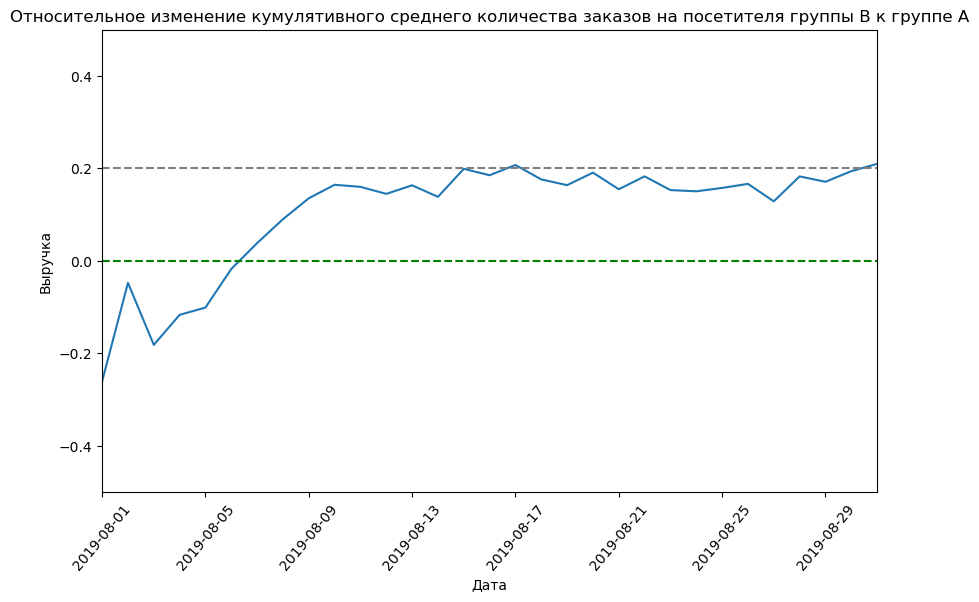

In [45]:
plt.figure(figsize = (10,6))
plt.plot(merged_cumulative_df['date'], merged_cumulative_df['conversionB']/merged_cumulative_df['conversionA'] -1)

plt.axhline(y=0, color='green', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.title('Oтносительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=50)

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.5, 0.5])

plt.show()

Группа В лидирует. Прирост относительно группы А составил почти 20%

### Точечный график количества заказов по пользователям

In [46]:
orders_by_users = orders.groupby('visitor_id', as_index = False).agg({'transaction_id' : 'nunique'})\
.sort_values(by = 'transaction_id', ascending = False)

orders_by_users.head()

,visitor_id,transaction_id
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


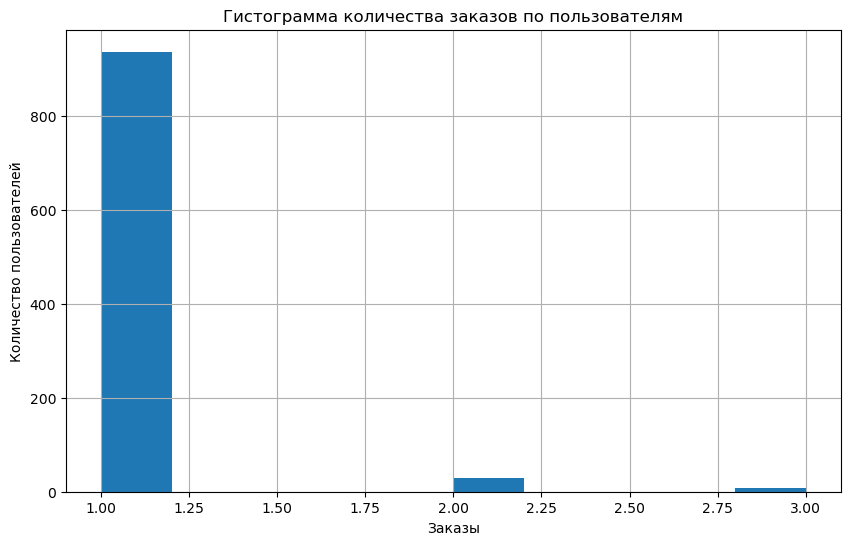

In [47]:
plt.figure(figsize = (10,6))
orders_by_users['transaction_id'].hist()
plt.title('Гистограмма количества заказов по пользователям')
plt.xlabel('Заказы')
plt.ylabel('Количество пользователей')
#plt.xticks(rotation=50)

plt.show()

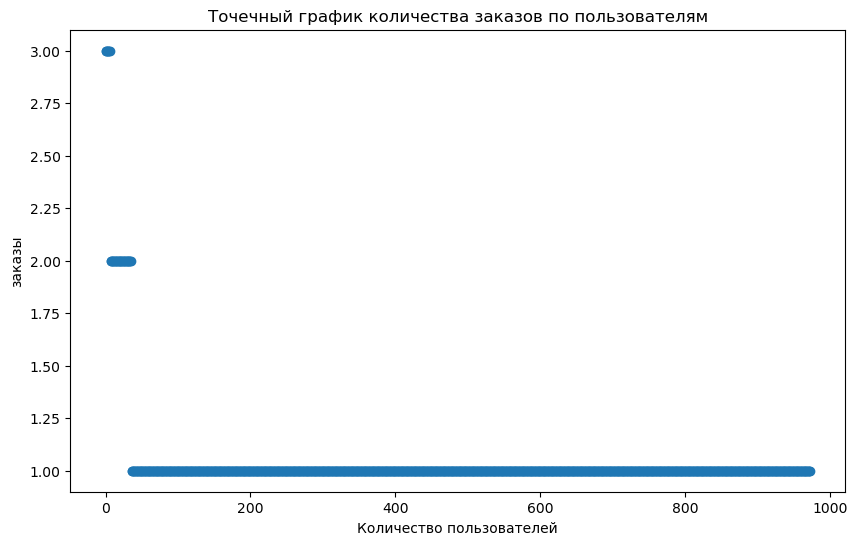

In [48]:
plt.figure(figsize = (10,6))
xval = pd.Series(range(0, len(orders_by_users)))
plt.scatter(xval, orders_by_users['transaction_id']) 

plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel ('заказы')
#plt.xticks(rotation=50)

plt.show()

В основном на одного клиента приходится по 1-2 заказа, реже до 4х, но есть аномальные значения с бОльшим числом заказов. Есть несколько пользователей, которые совершили больше 10 заказов

### Считаем 95-й и 99-й перцентили количества заказов на пользователя. Выбор границ для определения аномальных пользователей.

In [49]:
#order_by_users
np.percentile(orders_by_users['transaction_id'], [90, 95, 99])

array([1., 1., 2.])

Всего 1 процент пользователей совершил больше 4х заказов и не более 5% пользователей совершили больше 2х заказов. Иными словами 95% пользователей совершили всего 1-2 заказа (до изменений)

In [50]:
np.percentile(orders_by_users['transaction_id'], [90, 92, 93])

array([1., 1., 1.])

Можем наблюдать, что только 7% пользователей совершили больше 1 заказа

### Точечный график стоимостей заказов

In [51]:
orders.sort_values(by = 'revenue', ascending = False).head(10)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A
949,1347999392,887908475,2019-08-21,60450,A
940,2420050534,4003628586,2019-08-08,58550,B
131,3163614039,2254586615,2019-08-22,53904,A


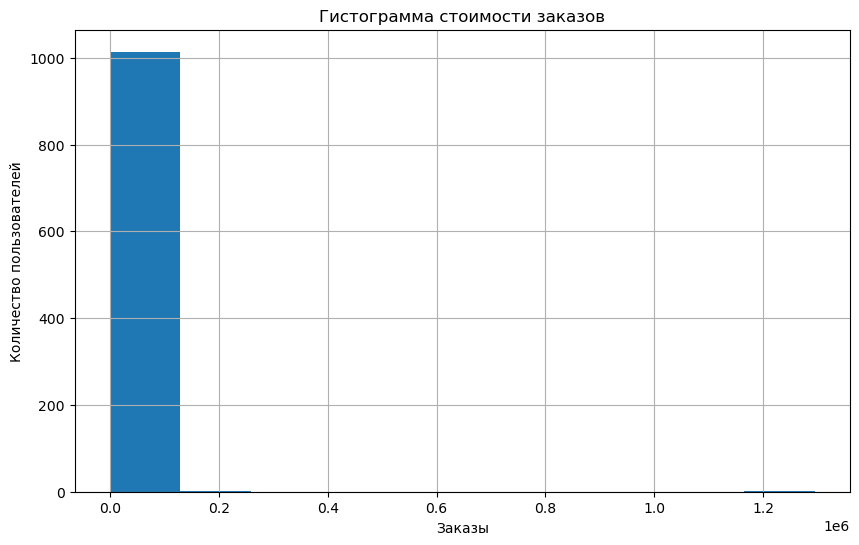

In [52]:

plt.figure(figsize = (10,6))
orders['revenue'].hist()
plt.title('Гистограмма стоимости заказов')
plt.xlabel('Заказы')
plt.ylabel('Количество пользователей')
#plt.xticks(rotation=50)

plt.show()

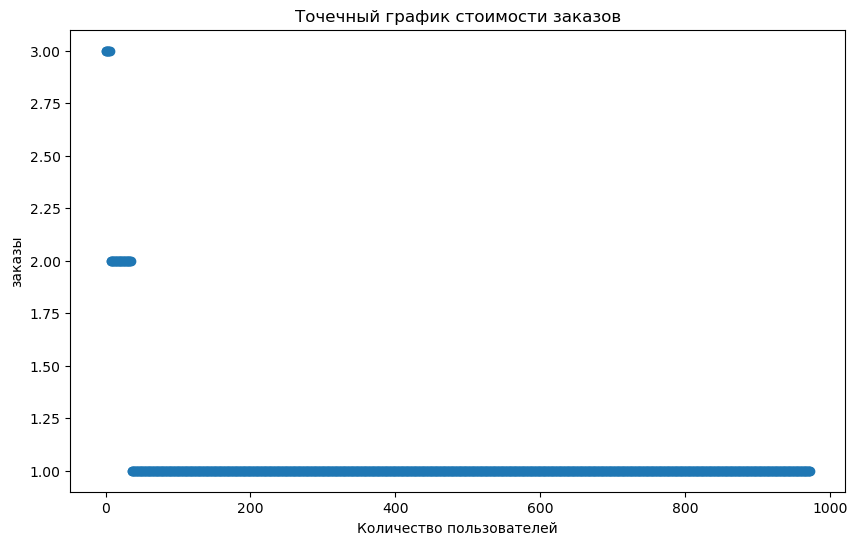

In [53]:
plt.figure(figsize = (10,6))
xval = pd.Series(range(0, len(orders_by_users)))
plt.scatter(xval, orders_by_users['transaction_id']) 

plt.title('Точечный график стоимости заказов')
plt.xlabel('Количество пользователей')
plt.ylabel ('заказы')
#plt.xticks(rotation=50)

plt.show()

Видим, что в стоимости заказов довольно мало выбросов. В основном все заказы стоимостью до 200000 у.е., но есть два выброса: один стоимостью 202740 у.е., другой 1294500 у.е. Любопытно, что оба выброса из группы В

### Считаем 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов.

In [54]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

95% пользователей совершили заказы на сумму до 28000 у.е. И только 1% пользователей совершил заказы на сумму больше 58233 у.е. 

In [55]:
np.percentile(orders['revenue'], [90, 92, 99])

array([17990., 19260., 53904.])

### Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

H0 = среднее количество заказов на посетителя между группами не отличается

H1 = среднее количество заказов на посетителя между группами отличается

In [56]:
# собираем посетителей группы А по дате
visitors_a = visitors.query('group == "A"')[['date', 'visitors']]
visitors_a.columns = ['date', 'visitors_a']

visitors_a_cummulative = visitors_a.apply(
    lambda x: visitors_a[visitors_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_a': 'sum'}), axis=1)

visitors_a_cummulative.columns = ['date', 'cumulative_a']


# собираем посетителей группы В по дате
visitors_b = visitors.query('group == "B"')[['date', 'visitors']]
visitors_b.columns = ['date', 'visitors_b']

visitors_b_cummulative = visitors_b.apply(
    lambda x: visitors_b[visitors_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_b': 'sum'}), axis=1)

visitors_b_cummulative.columns = ['date', 'cumulative_b']

In [57]:
# собираем заказы группы А по дате
orders_a = (
    orders.query('group =="A"')[['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))

orders_a.columns = ['date', 'orders_a', 'revenue_a']


orders_a_cummulative = orders_a.apply(
    lambda x: orders_a[orders_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_a': 'sum', 'revenue_a': 'sum'}),
    axis=1).sort_values(by=['date'])

orders_a_cummulative.columns = ['date','cumorders_a', 'cumrevenue_a']


#собираем заказы группы В по дате
orders_b = (
    orders.query('group =="B"')[['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))

orders_b.columns = ['date', 'orders_b', 'revenue_b']


orders_b_cummulative = orders_b.apply(
    lambda x: orders_b[orders_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_b': 'sum', 'revenue_b': 'sum'}),
    axis=1).sort_values(by=['date'])

orders_b_cummulative.columns = ['date','cumorders_b', 'cumrevenue_b']

In [58]:
data = (
    orders_a.merge(
        orders_b, left_on='date', right_on='date', how='left')
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a, left_on='date', right_on='date', how='left')
    .merge(visitors_b, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left'))

data.head(5)

,date,orders_a,revenue_a,orders_b,revenue_b,cumorders_a,cumrevenue_a,cumorders_b,cumrevenue_b,visitors_a,visitors_b,cumulative_a,cumulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [59]:
# собираем уникальные заказы группы А для каждого пользователя 
orders_by_user_a = (
    orders.query('group == "A"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique}))

orders_by_user_a.columns = ['user_id', 'orders']

# собираем уникальные заказы группы В для каждого пользователя 
orders_by_user_b = (
    orders.query('group == "B"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique}))

orders_by_user_b.columns = ['user_id', 'orders']

In [60]:
# создает Series с данными по заказам, пробелы заполняем нулями
sample_a = pd.concat([orders_by_user_a['orders'],pd.Series(0,index=np.arange(
    data['visitors_a'].sum() - len(orders_by_user_a['orders'])), name='orders')],
    axis=0,)


# создает Series с данными по заказам, пробелы заполняем нулями
sample_b = pd.concat([orders_by_user_b['orders'],pd.Series(0,index=np.arange(
    data['visitors_b'].sum() - len(orders_by_user_b['orders'])), name='orders')],
    axis=0,)

In [61]:
print("p-value {0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print("разница средних {0:.3f}".format((data['orders_b'].sum()/data['visitors_b'].sum())/(data['orders_a'].sum()/data['visitors_a'].sum())-1)) 

p-value 0.011
разница средних 0.160



Значение p<0.011, значит нулевую гипотезу отвергаем. Получается, что среднее количество заказов на посетителя между группами отличается. Разница в средних количествах заказов 16%

###  Считаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

H0 = средний чек между группами не отличается

H1 = средний чек между группами отличается

In [62]:
print('p-value {0:.3f}'.format(stats.mannwhitneyu(orders.query('group =="A"')['revenue'], orders.query('group =="B"')['revenue'])[1]))
print('разница в средних {0:.3f}'.format(orders.query('group =="B"')['revenue'].mean()/orders.query('group =="A"')['revenue'].mean()-1))

p-value 0.829
разница в средних 0.287



Средний чек отличается на 28.7%, но статистически значимых различий не обнаружено, следовательно нулевую гипотезу не отвергаем. Значит, принимаем, что средний чек между группами не отличается

### Считаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

H0 = среднее количество заказов на посетителя между группами не отличается

H1 = среднее количество заказов на посетителя между группами отличается

In [63]:
orders_by_user_a['orders'].value_counts()

1    427
2     13
3      5
Name: orders, dtype: int64

In [64]:
revenue_lim = np.percentile(orders['revenue'], 95)

many_orders = pd.concat(
    [
        orders_by_user_a.query('orders > 4')['user_id'],
        orders_by_user_b.query('orders > 4')['user_id'],
    ],
    axis=0,
)

big_revenue = orders.query('revenue > @revenue_lim')['visitor_id']

abnormal_users = (
    pd.concat([many_orders, big_revenue], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print("*" *20)
print(abnormal_users.shape[0]) 

568     113298937
1099    148427295
928     204675465
684     358944393
648     382846391
dtype: int64
********************
51


In [65]:
sample_a_filtered = pd.concat([orders_by_user_a[np.logical_not(orders_by_user_a['user_id'].isin(abnormal_users))]['orders'],\
                               pd.Series(0, index = np.arange(data['visitors_a']\
                                .sum() - len(orders_by_user_a['orders'])), name = 'orders')], axis = 0)

sample_b_filtered = pd.concat([orders_by_user_b[np.logical_not(orders_by_user_b['user_id'].isin(abnormal_users))]['orders'],\
                               pd.Series(0, index = np.arange(data['visitors_b']\
                                .sum() - len(orders_by_user_b['orders'])), name = 'orders')], axis = 0)

In [66]:
print('p-value {0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('разница в средних {0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)) 

p-value 0.017
разница в средних 0.156


Статистические различия по-прежнему есть. То есть нулевую гипотезу мы отвергаем, принимаем альтернативную - различия в количестве заказов между двумя группами есть. Разница в средних значениях 15.6%

### Считаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

H0 = различий в среднем чеке нет

H1 = различия в среднем чеке есть

In [67]:
print('p-value {0:.3f}'.format(stats.mannwhitneyu(
                orders[np.logical_and(orders['group'] == 'A',\
                np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
                
                orders[np.logical_and(orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])[1]))

print("разница в средних {0:.3f}".format(
                orders[np.logical_and(orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()
                
                / orders[np.logical_and(orders['group'] == 'A', 
                np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()- 1)) 

p-value 0.741
разница в средних -0.053




Различия в среднем чеке минимальны, поэтому различия оказываются недостоверными. Следовательно нулевую гипотезу не отвергаем и принимаем нулевую гипотезу о том, что различий в среднем чеке нет

## Выводы


В начале данные были предобработаны: названия столбов приведены к нижнему регистру, а также изменены названия столбов для удобства. В целом данные получены в хорошем состоянии, без дубликатов, пропусков и тд. Однако в данных были сведения о пользователях, которые попали в обе тестовые группы. Пользователей, совершивших более 2х покупок было принято решение удалить из выборки. 

Была проведена приоритизация гипотез по ICE и RICE. По Ice лидирует гипотеза: "Запустить акцию, дающую скидку на товар в день рождения". Согласно фреймворку RICE - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Теория по Rice могут иметь больший приоритет по прчине того, что её введение отразится на большем числе пользователей при той же стоимости проведения. В то же время теория по ICE вызывает большую уверенность и лучше отразится а опыте пользования продуктом.

Всего 1% пользователей совершил больше 4х заказов и не более 7% пользователей совершили больше 2х заказов. Иными словами 95% пользователей совершили всего 1-2 заказа
95% пользователей совершили заказы на сумму до 28000 у.е. И только 1% пользователей совершил заказы на сумму больше 58233 у.е.

По результатам А/В теста видим, что среднее количество заказов на посетителя между группами отличается. У группы В в среднем заказов больше на 16%. После очистки данных группа В также имеет большее количество заказов, а разница увеличилась до 15.6%. 
Разницы между средними чеками нет ни в одном из случаев. 

Тест рекомендуется остановить т.к. данных достаточно для уставновления статистических различий между группами теста. Таким образом можем считать, что группа В показала лучший результат в количестве заказов. 
